# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ydata_profiling import ProfileReport

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offer = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

C:\Users\logan\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [3]:
df_offer.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offer.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head(15)

C:\Users\logan\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


customer_name  offer_id  n
0          Smith         2  1
1          Smith        24  1
2        Johnson        17  1
3        Johnson        24  1
4        Johnson        26  1
5       Williams        18  1
6       Williams        22  1
7       Williams        31  1
8          Brown         7  1
9          Brown        29  1
10         Brown        30  1
11         Jones         8  1
12        Miller         6  1
13        Miller        10  1
14        Miller        14  1

## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
#your turn
df_pivot = df_transactions.pivot(index = 'customer_name', columns = ['offer_id'])
df_pivot.fillna(0, inplace = True)
df_pivot.columns = df_pivot.columns.get_level_values(1)
df_pivot.columns = df_pivot.columns.astype(str)
offer_cols = df_pivot.columns
df_pivot[offer_cols] = df_pivot[offer_cols].astype('int')
df_pivot.head()

offer_id       1  2  3  4  5  6  7  8  9  10  ...  23  24  25  26  27  28  29  \
customer_name                                 ...                               
Adams          0  0  0  0  0  0  0  0  0   0  ...   0   0   0   0   0   0   1   
Allen          0  0  0  0  0  0  0  0  1   0  ...   0   0   0   0   1   0   0   
Anderson       0  0  0  0  0  0  0  0  0   0  ...   0   1   0   1   0   0   0   
Bailey         0  0  0  0  0  0  1  0  0   0  ...   0   0   0   0   0   0   0   
Baker          0  0  0  0  0  0  1  0  0   1  ...   0   0   0   0   0   0   0   

offer_id       30  31  32  
customer_name              
Adams           1   0   0  
Allen           0   0   0  
Anderson        0   0   0  
Bailey          1   0   0  
Baker           0   1   0  

[5 rows x 32 columns]

In [6]:
df_pivot.shape

(100, 32)

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

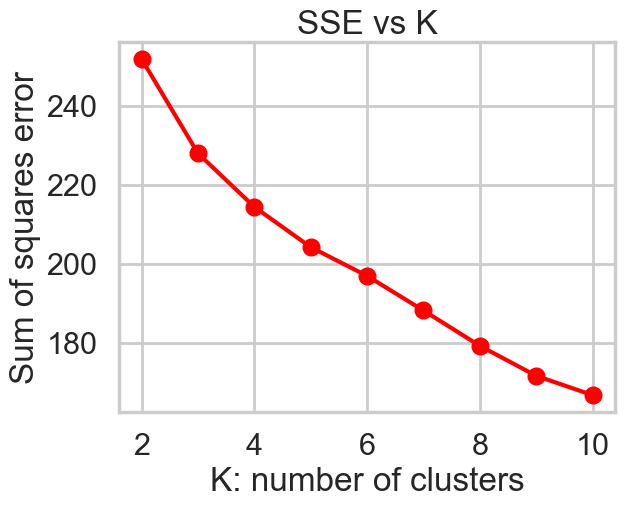

In [7]:
from sklearn.cluster import KMeans

x_cols_df = df_pivot.reset_index(drop = True)
x_cols = x_cols_df.to_numpy()

inertia = []
for k in range(2,11):
    model = KMeans(n_clusters = k, random_state = 14)
    model.fit(x_cols)
    inertia.append(model.inertia_)
    
plt.plot(range(2, 11), inertia, marker = 'o', c = 'r')
plt.xlabel('K: number of clusters')
plt.ylabel('Sum of squares error')
plt.title('SSE vs K')
plt.show()

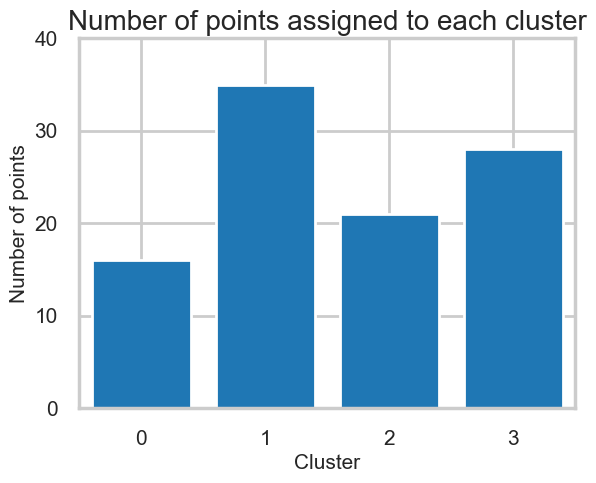

In [8]:
# Choose K = 4

k = 4
model = KMeans(n_clusters = k, random_state = 14)
labels = model.fit_predict(x_cols)

plt.bar(range(k), np.bincount(labels))
plt.xlabel('Cluster', fontsize = 15)
plt.ylabel('Number of points', fontsize = 15)
plt.title('Number of points assigned to each cluster', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(-0.5, 3.5)
plt.ylim(0, 40)
plt.show()


#### Answer ####
Lower values of SS correspond with better clusterings to an extent. As SS decreases, it means that the cluster centers are well centralized to the data points that surround them. However, we could theoretically have as many cluster centers as data points with an SS of 0. This isn't a useful model, though. We employ the elbow method to see where we begin to lose the benefits of adding more cluster centers. In this case, there isn't a very clear inflection point in the graph, likely because the data have so many dimensions. This is a limitation of the elbow method, because it relies on intuition instead of a set threshold.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For 2 clusters, the silhouette score is 0.08206113079944462.
For 3 clusters, the silhouette score is 0.12122715317053197.
For 4 clusters, the silhouette score is 0.13631345856862404.
For 5 clusters, the silhouette score is 0.12057093492403308.
For 6 clusters, the silhouette score is 0.1328333955273201.
For 7 clusters, the silhouette score is 0.12815640307473208.
For 8 clusters, the silhouette score is 0.12841462477376744.
For 9 clusters, the silhouette score is 0.12334931451939363.
For 10 clusters, the silhouette score is 0.11686672419454908.


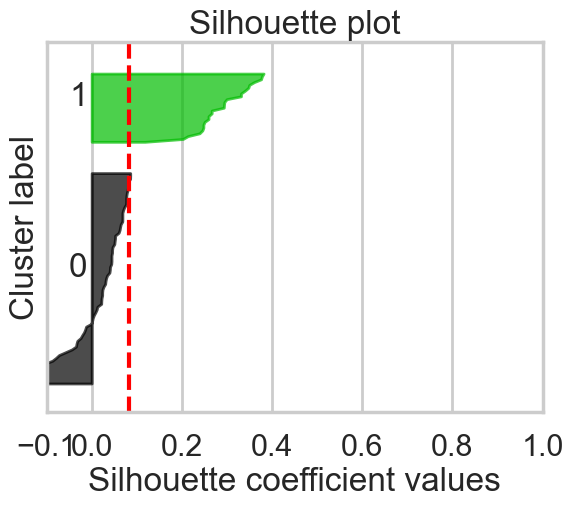

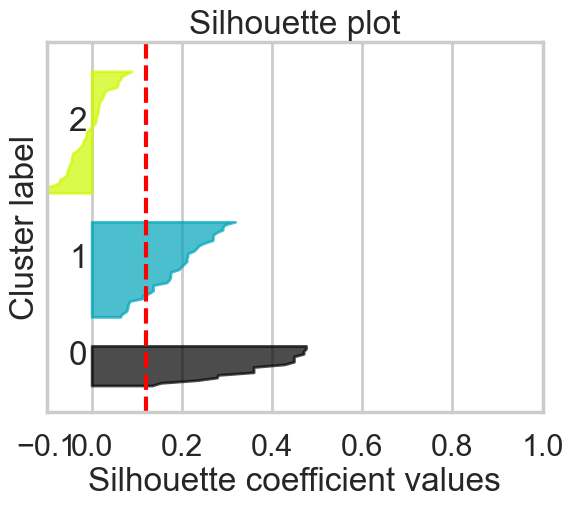

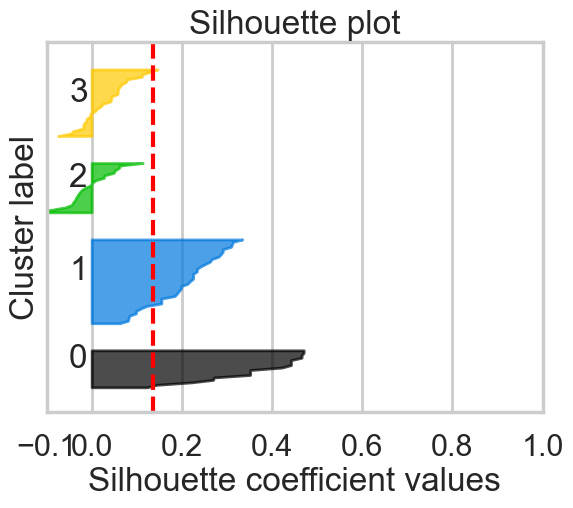

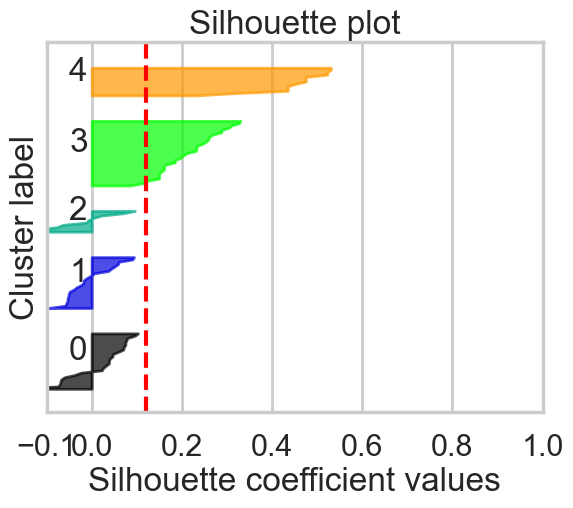

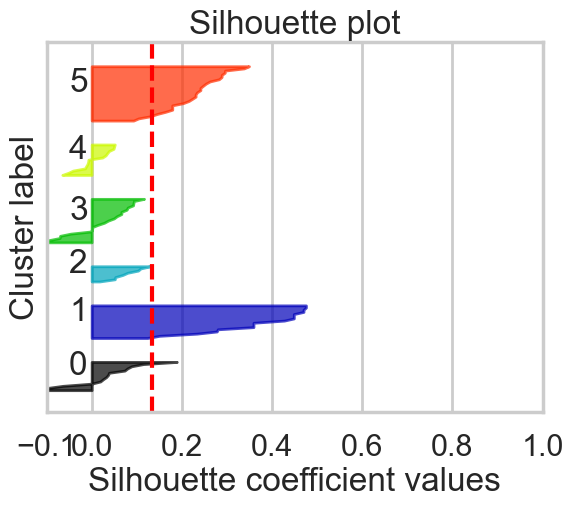

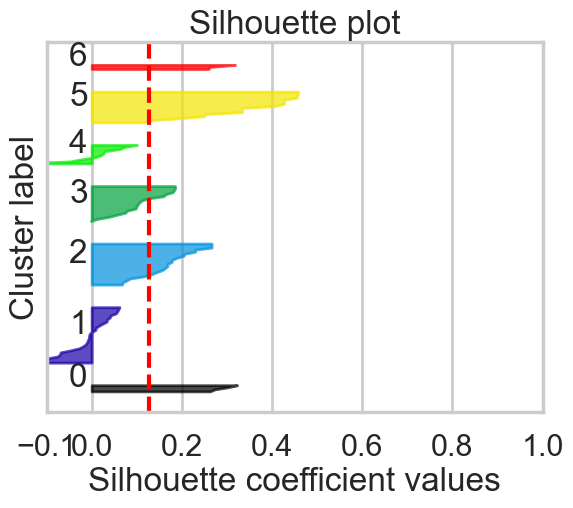

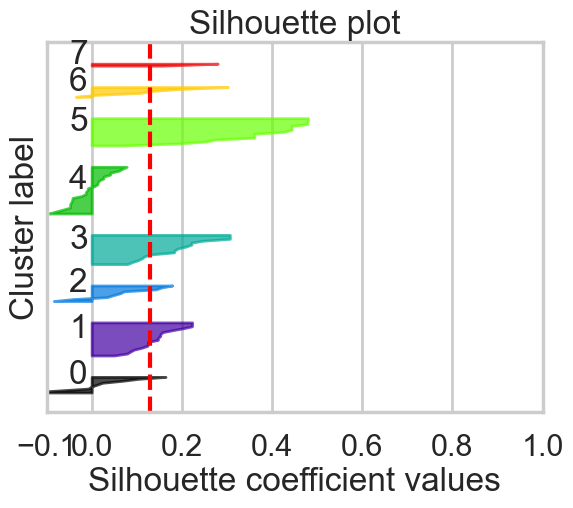

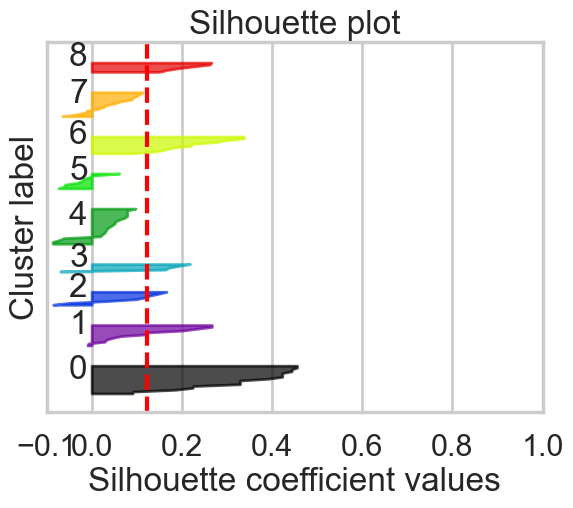

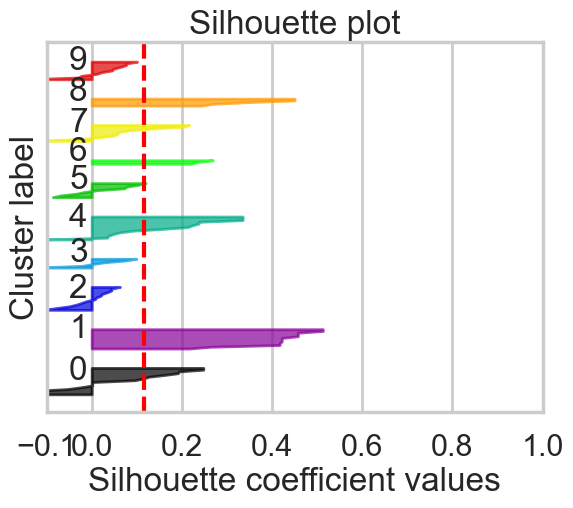

In [9]:
# Your turn.
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
scores = []
for k in range(2, 11):
    fig, (ax1) = plt.subplots(1, 1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_cols) + (k + 1) * 10])
    
    model = KMeans(n_clusters = k, random_state = 14)
    labels = model.fit_predict(x_cols)
    
    silhouette_avg = silhouette_score(x_cols, labels)
    scores.append(silhouette_avg)
    print(f'For {k} clusters, the silhouette score is {silhouette_avg}.')
    
    sample_silhouette_values = silhouette_samples(x_cols, labels)
    
    y_lower = 10
    
    for i in range(k):
        i_values = sample_silhouette_values[labels == i]
        
        i_values.sort()
        
        size_i = i_values.shape[0]
        y_upper = y_lower + size_i
        
        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            i_values,
            facecolor = color,
            edgecolor = color,
            alpha = 0.7,
        )
        
        ax1.text(-.05, y_lower + 0.5 * size_i, str(i))
        
        y_lower = y_upper + 10
        
    ax1.set_title('Silhouette plot')
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster label')
    
    ax1.axvline(x = silhouette_avg, color = 'red', linestyle = '--')
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    colors = cm.nipy_spectral(labels.astype(float) / k)

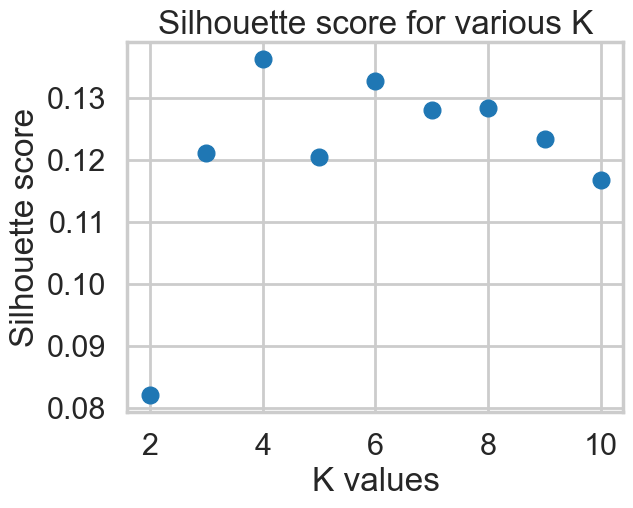

In [10]:
plt.plot(range(2, 11), scores, linestyle = 'none', marker = 'o')
plt.xlabel('K values')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for various K')
plt.show()

#### Answer ####
The silhouette scores agree with the K value from the elbow method, but it is easier to see why 4 clusters is a good choice from this metric.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

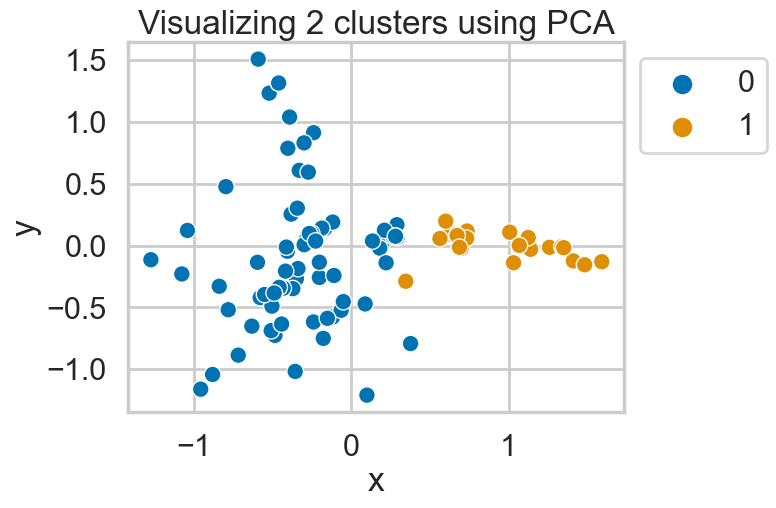

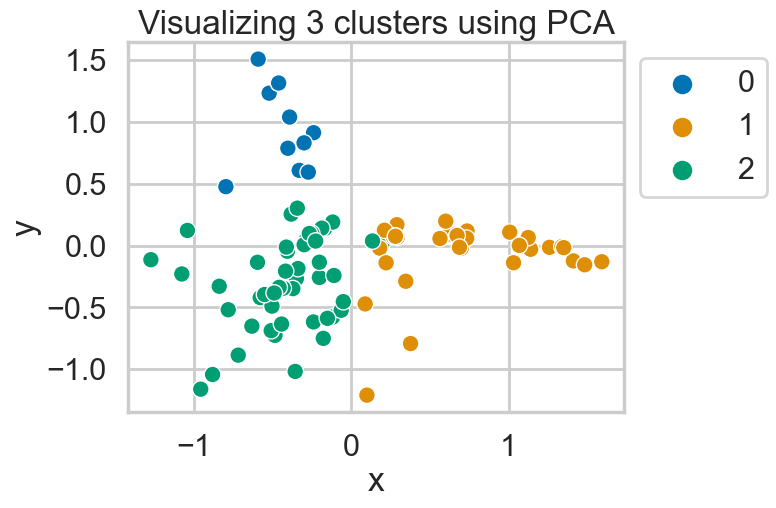

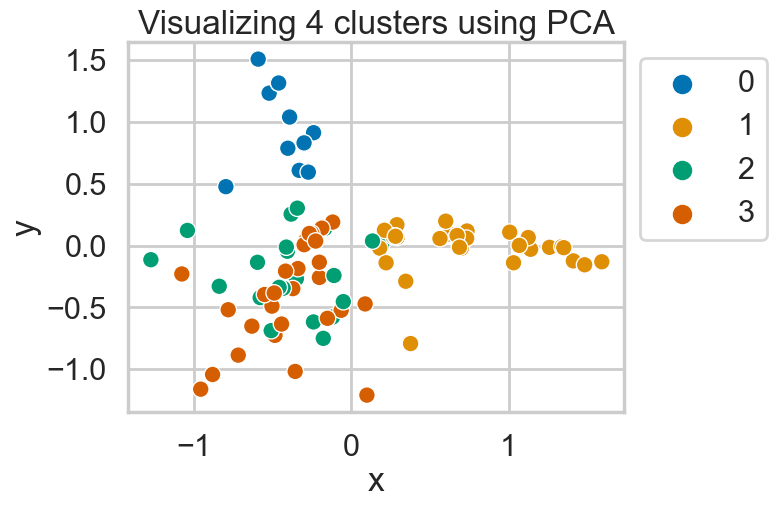

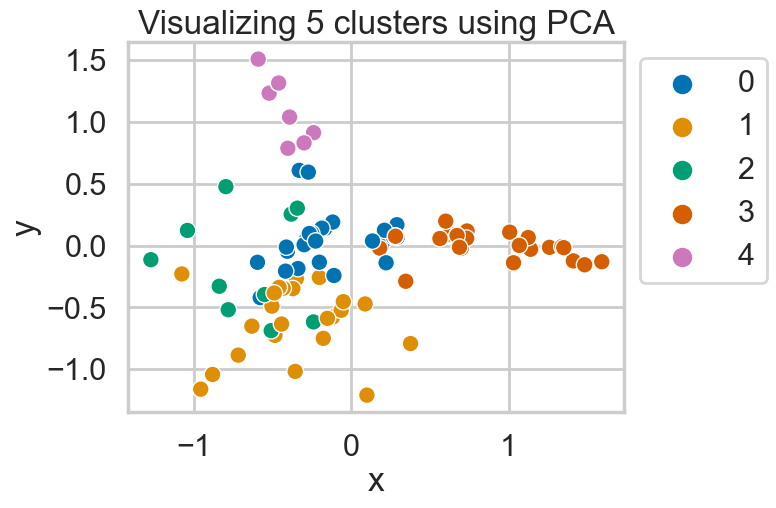

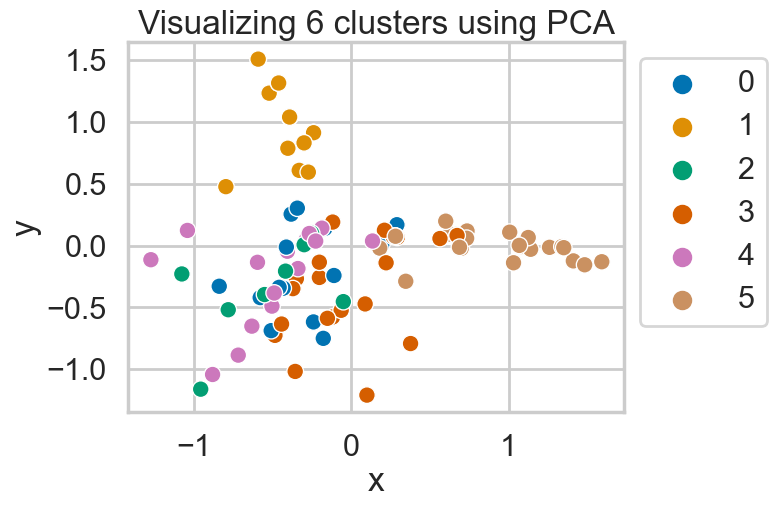

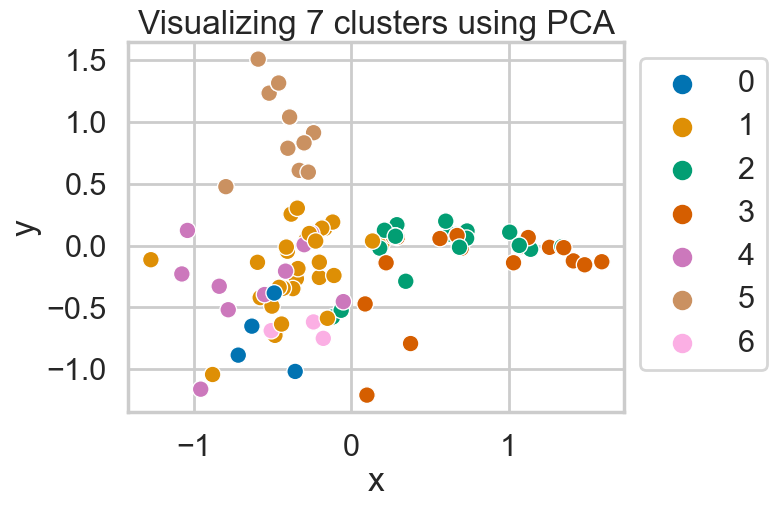

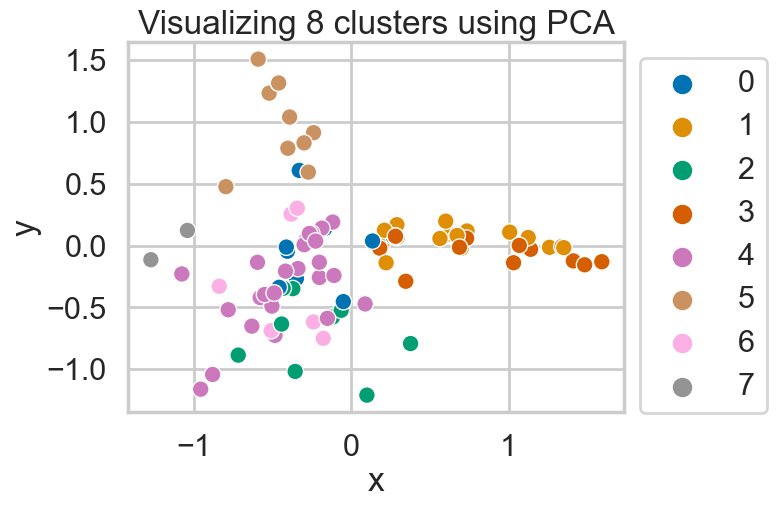

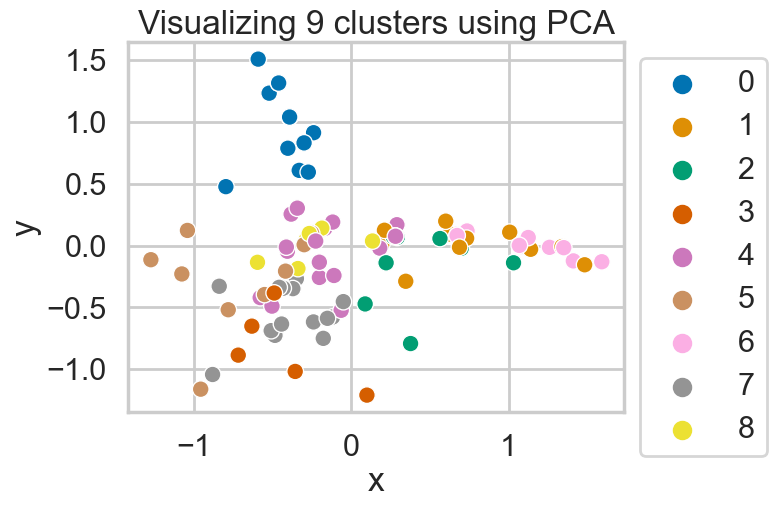

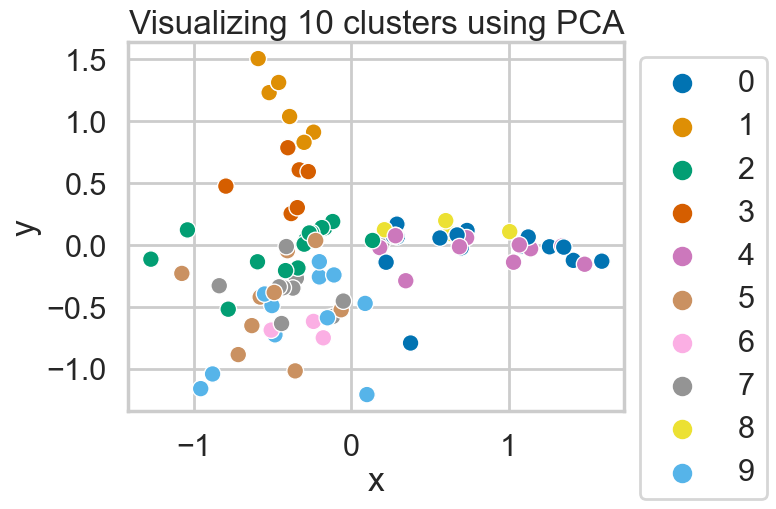

In [11]:
from sklearn.decomposition import PCA

label_names = list(range(0, 11))
colors = sns.color_palette('colorblind', len(label_names))
palette = {label_name: color for label_name, color in zip(label_names, colors)}

for k in range(2, 11):
    fig, ax = plt.subplots(1, 1)

    model = KMeans(n_clusters = k, random_state = 14)
    labels = model.fit_predict(x_cols)

    pca = PCA()
    df_pca = pd.DataFrame(pca.fit_transform(x_cols_df), columns = [f'PC{i}' for i in range(1, len(x_cols_df.columns)+1)])

    df_labels = pd.DataFrame(df_pivot.reset_index()['customer_name'])
    df_labels['cluster_id'] = labels
    df_labels['x'] = df_pca['PC1']
    df_labels['y'] = df_pca['PC2']
    df_labels.head()

    _ = sns.scatterplot(data = df_labels, x = 'x', y = 'y', hue = 'cluster_id', palette = palette).set_title(f'Visualizing {k} clusters using PCA')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

#### Answer ####

The clusters certainly overlap, which is to be expected when we reduce dimensionality from 32 to 2. However, with 2 principal components, it appears that 3 clusters gets us better segmentation than 4 clusters. This K value clashes with the silhouette score, which indicated that 3 clusters would underperform compared to 4 or more clusters.

The clusters inform us which customers are most likely to act in certain ways. As seen below, for example, customers in cluster 0 were most likely to buy Pinot Noir, so it makes sense to advertise new Pinot Noirs to this group. Cluster 1 customers were most likely to buy sparkling wines, provided the minimum volume was low. This customer segment also seemed to respond well to steep discounts, so they would be good targets for sale ads. 

Clustering customers in this way allows a business to maximize the efficiency of their ad spend dollars and avoid ad fatigue.

In [12]:
cust_model = KMeans(n_clusters = 4, random_state = 14)
cust_labels = cust_model.fit_predict(x_cols)

df_cust = pd.DataFrame(df_pivot.reset_index()['customer_name'])
df_cust['cluster_id'] = cust_labels.astype('int')
df_offers = df_cust.merge(df_pivot, on = 'customer_name', how = 'outer')

df_offers.set_index(['cluster_id'], inplace = True)
df_offers.sort_index(inplace = True)
df_offers.drop('customer_name', axis = 1, inplace = True)
df_means = df_offers.groupby('cluster_id').mean().round(3)
df_means.head()

1      2      3      4      5      6      7      8      9  \
cluster_id                                                                  
0           0.062  0.375  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1           0.000  0.000  0.057  0.000  0.000  0.029  0.457  0.486  0.000   
2           0.333  0.190  0.048  0.238  0.048  0.048  0.000  0.048  0.190   
3           0.071  0.000  0.107  0.250  0.107  0.357  0.107  0.071  0.214   

               10  ...     23    24     25     26     27     28     29     30  \
cluster_id         ...                                                          
0           0.062  ...  0.062  0.75  0.000  0.750  0.062  0.000  0.000  0.000   
1           0.057  ...  0.000  0.00  0.000  0.000  0.029  0.029  0.457  0.457   
2           0.000  ...  0.000  0.00  0.286  0.095  0.048  0.238  0.048  0.286   
3           0.143  ...  0.143  0.00  0.000  0.036  0.214  0.000  0.000  0.000   

               31     32  
cluster_id                
0           0.000  0.000  
1           0.000  0.000  
2           0.190  0.095  
3           0.464  0.071  

[4 rows x 32 columns]

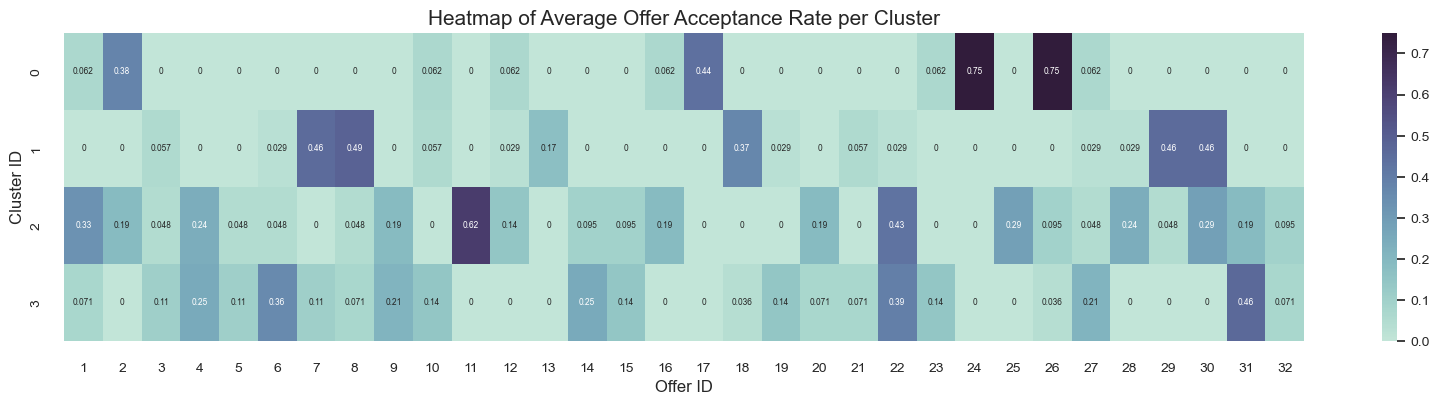

In [13]:
fig, ax = plt.subplots(figsize = (20, 4))
ax.tick_params(labelsize=10)
sns.set(font_scale = 0.5)
sns.heatmap(df_means, square = False, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), annot = True)
cbar = ax.collections[0].colorbar

cbar.ax.tick_params(labelsize=10)
plt.xlabel('Offer ID', fontsize = 12)
plt.ylabel('Cluster ID', fontsize = 12)
plt.title('Heatmap of Average Offer Acceptance Rate per Cluster', fontsize = 15)
plt.show()

In [14]:
df_offer[(df_offer['offer_id'] == 24) | (df_offer['offer_id'] == 26)]

offer_id   campaign    varietal  min_qty  discount     origin  past_peak
23        24  September  Pinot Noir        6        34      Italy      False
25        26    October  Pinot Noir      144        83  Australia      False

In [15]:
df_offer[df_offer['varietal'] == 'Pinot Noir']

offer_id   campaign    varietal  min_qty  discount     origin  past_peak
1          2    January  Pinot Noir       72        17     France      False
16        17       July  Pinot Noir       12        47    Germany      False
23        24  September  Pinot Noir        6        34      Italy      False
25        26    October  Pinot Noir      144        83  Australia      False

In [16]:
df_offer[(df_offer['varietal'] == 'Espumante') | (df_offer['varietal'] == 'Prosecco')]

offer_id  campaign   varietal  min_qty  discount        origin  past_peak
2          3  February  Espumante      144        32        Oregon       True
5          6     March   Prosecco      144        86         Chile      False
6          7     March   Prosecco        6        40     Australia       True
7          8     March  Espumante        6        45  South Africa      False
9         10     April   Prosecco       72        52    California      False
11        12       May   Prosecco       72        83     Australia      False
17        18      July  Espumante        6        50        Oregon      False

In [17]:
df_offer[(df_offer['offer_id'] == 7) | (df_offer['offer_id'] == 8) | (df_offer['offer_id'] == 18) | (df_offer['offer_id'] == 29) | (df_offer['offer_id'] == 30)]

offer_id  campaign      varietal  min_qty  discount        origin  \
6          7     March      Prosecco        6        40     Australia   
7          8     March     Espumante        6        45  South Africa   
17        18      July     Espumante        6        50        Oregon   
28        29  November  Pinot Grigio        6        87        France   
29        30  December        Malbec        6        54        France   

    past_peak  
6        True  
7       False  
17      False  
28      False  
29      False

In [18]:
df_offer['discount'].describe()

count    32.000000
mean     57.843750
std      20.770807
min      17.000000
25%      44.750000
50%      55.000000
75%      82.250000
max      89.000000
Name: discount, dtype: float64

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

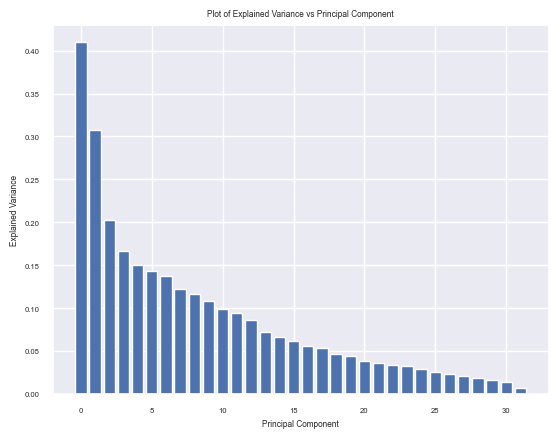

In [19]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit_transform(x_cols_df)

variance = pca.explained_variance_

plt.bar(range(0,len(variance)), variance)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Component')
plt.title('Plot of Explained Variance vs Principal Component')
plt.show()

#### Answer ####

After 3 principal components, we see sharply diminishing returns in the variance explained by additional components. As such, performing the principal component analysis in three dimensions likely will help visualize the clusters better.

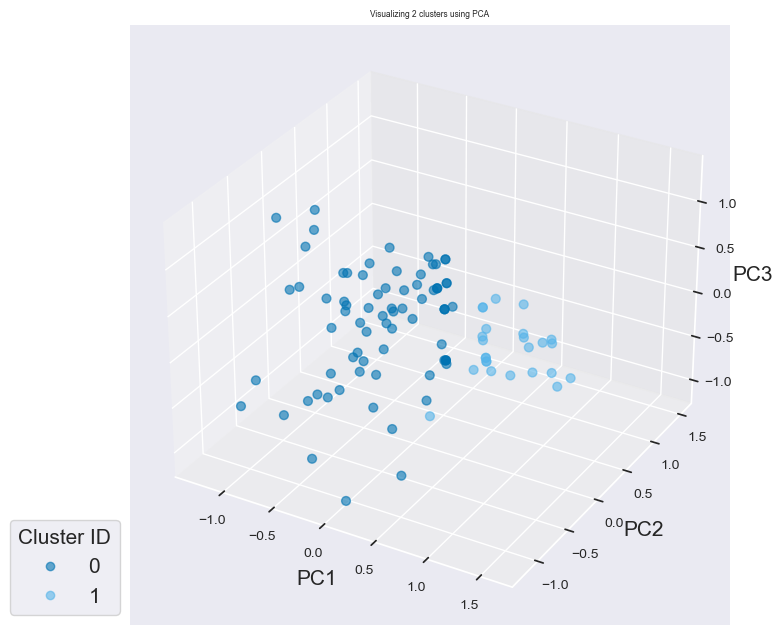

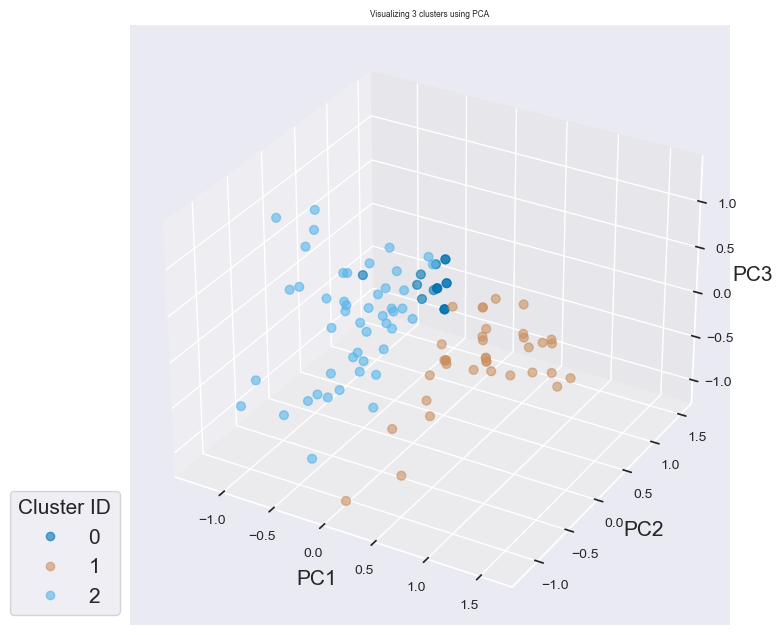

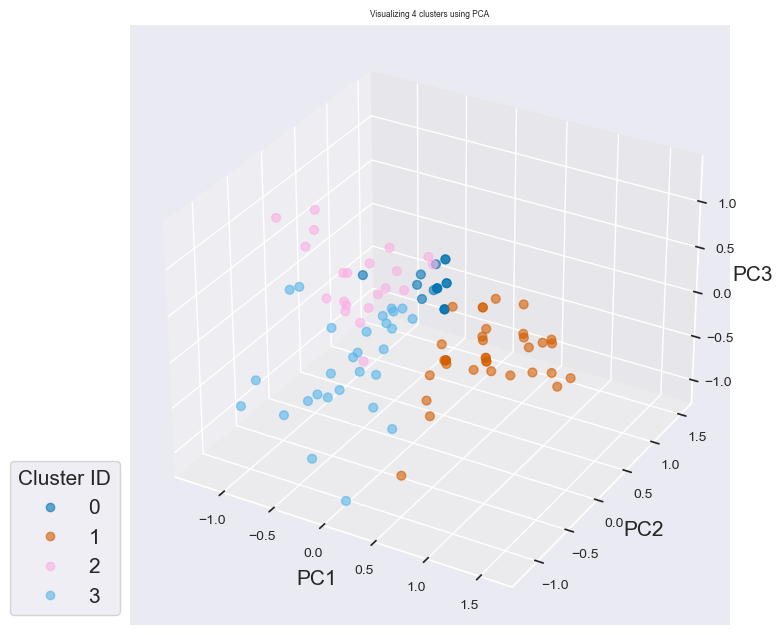

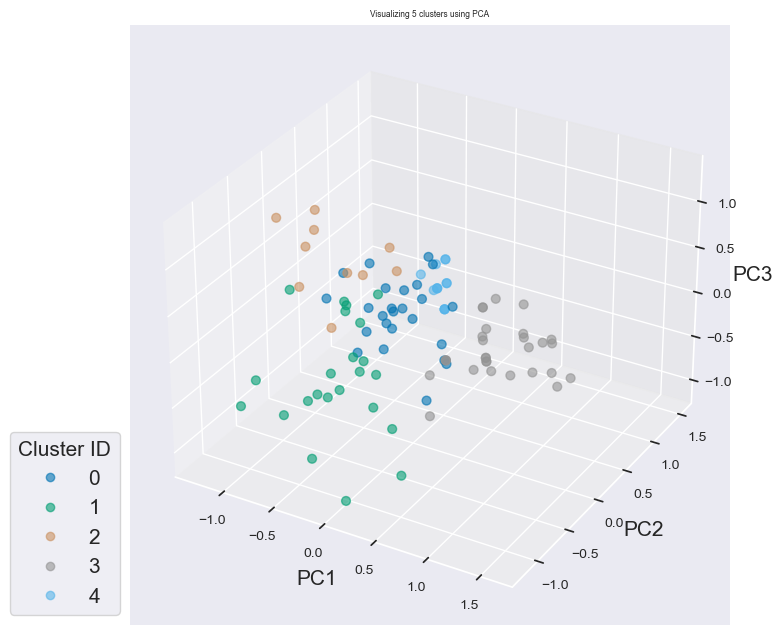

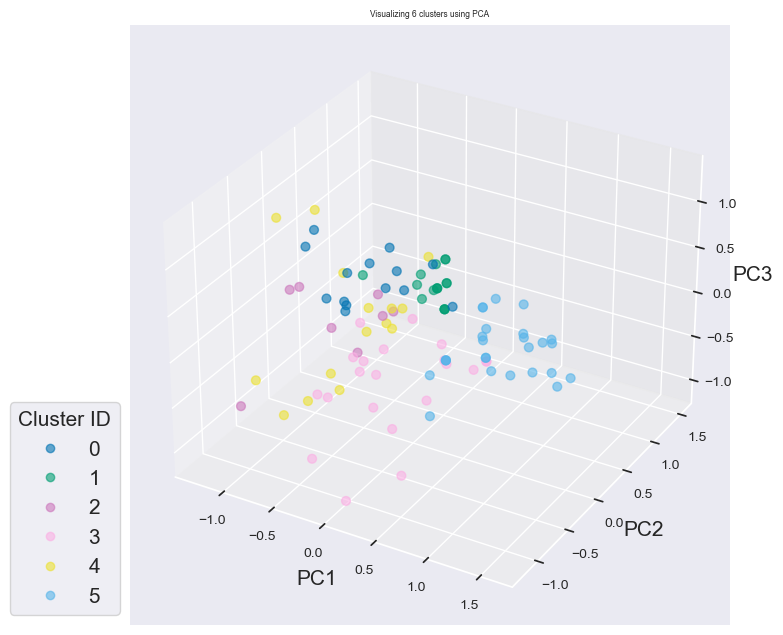

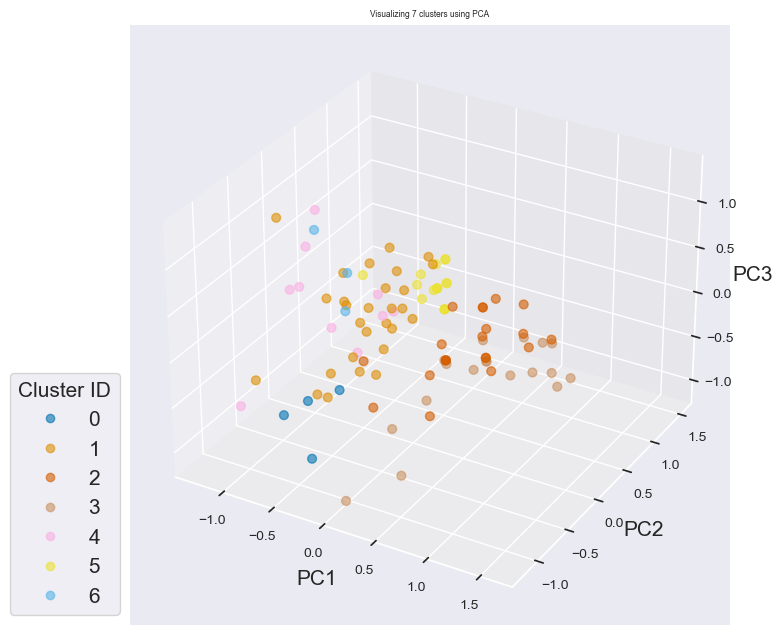

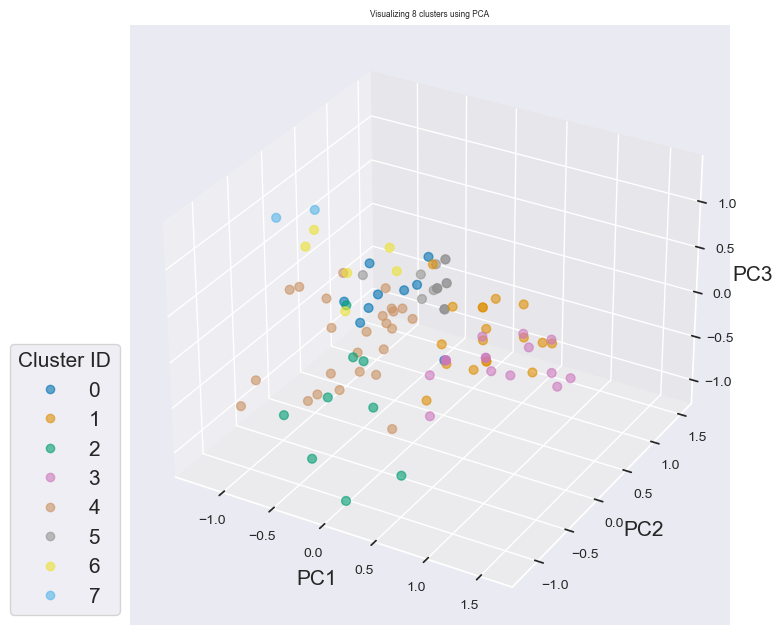

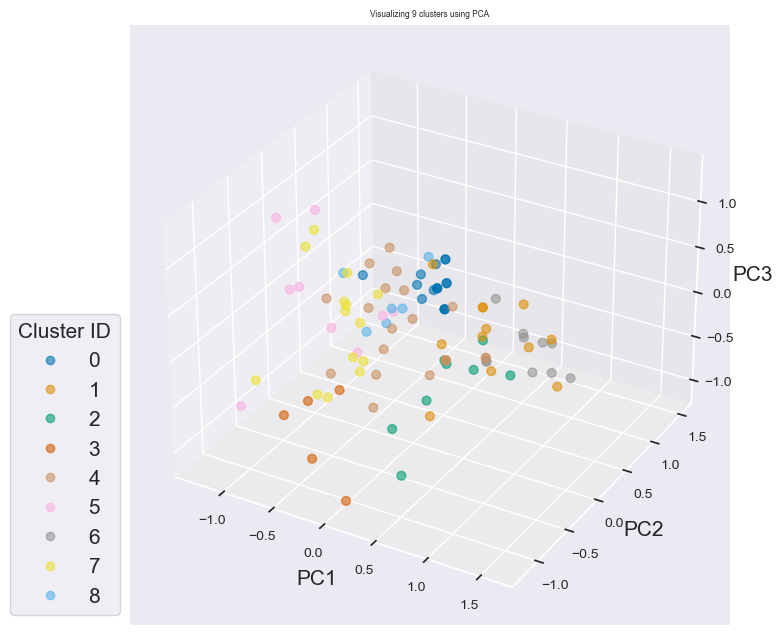

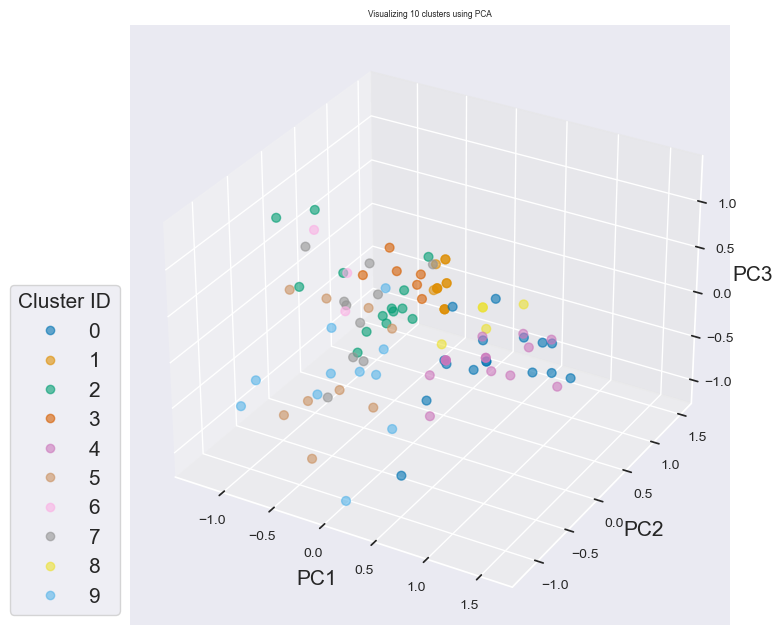

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

for k in range(2, 11):
    fig = plt.figure(figsize=(6,8))
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)

    model = KMeans(n_clusters = k, random_state = 14)
    labels = model.fit_predict(x_cols)

    pca = PCA()
    df_pca = pd.DataFrame(pca.fit_transform(x_cols_df), columns = [f'PC{i}' for i in range(1, len(x_cols_df.columns)+1)])

    df_labels = pd.DataFrame(df_pivot.reset_index()['customer_name'])
    df_labels['cluster_id'] = labels
    x = df_pca['PC1']
    y = df_pca['PC2']
    z = df_pca['PC3']
    df_labels.head()
    
    cmap = ListedColormap(sns.color_palette('colorblind').as_hex())
    
    sc = ax.scatter(x, y, z, s=40, c=df_labels['cluster_id'], cmap = cmap, marker='o', alpha=0.6)
    ax.set_xlabel('PC1', fontsize = 15)
    ax.set_ylabel('PC2', fontsize = 15)
    ax.set_zlabel('PC3', fontsize = 15)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title(f'Visualizing {k} clusters using PCA')
    plt.legend(title = 'Cluster ID', *sc.legend_elements(), loc='lower right', bbox_to_anchor=(0, 0), fontsize = 15, title_fontsize = 15)
plt.show()

#### Answer ####

Viewing the clusters in 3 dimensions allows us to better visualize the separation of clusters. We can more clearly see that the 4 clusters are separated in the 3rd dimension, though plenty of overlap still seems to exist.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

#### Answer ####

Due to the nature of PCA, it will never be possible to perfectly represent such highly dimensional data in 2D or 3D for the purposes of optimizing clusters. Silhouette score does a good job, especially when the elbow plot is inconclusive.


### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [21]:
# Your turn
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation(damping = 0.5, random_state = 14)
ap_labels = ap.fit_predict(x_cols_df)
print(ap_labels)

[ 0 10  6  3 12 12  6  7  4  2  9 13  2 12  4  6  3  6  0  1  2  7  4  9
  6 10 11  4 10 13  3  7  4  8 12  5  4  2  4  5  6  6  7 12  0  8  2  3
 10 13  1 12 13  6  3  7  6  3  0 12 12  7 12  0  0 13  6 11  9 10 11 10
  8  3 12  3 13  7  3 13 11 10 11 13  2  5  0 10 10  7 12  0  3  3  1 12
  7 12  8 10]


In [22]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters = 4, random_state = 14)
sc_labels = sc.fit_predict(x_cols_df)
print(sc_labels)

[0 2 1 0 2 2 1 3 2 0 2 1 0 2 0 1 2 1 0 2 0 3 2 2 1 2 2 2 2 1 0 3 2 2 0 3 2
 0 2 0 1 1 3 2 0 2 0 0 2 2 2 2 2 1 2 3 1 0 0 3 2 3 2 0 0 1 1 2 2 2 2 2 2 0
 2 0 1 2 0 1 2 2 2 1 3 3 0 2 2 3 2 0 2 0 2 2 3 2 2 2]


In [23]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters = 4)
ac_labels = ac.fit_predict(x_cols_df)
print(ac_labels)

[1 0 2 1 0 0 2 1 0 1 0 2 1 0 1 2 0 2 1 0 1 1 3 0 2 0 0 0 0 2 1 1 0 3 1 1 0
 1 0 1 2 2 1 0 1 3 1 0 0 0 0 0 2 2 3 1 2 1 1 0 0 1 0 1 1 2 2 0 0 0 0 0 3 1
 0 1 2 3 1 2 0 0 0 2 1 1 1 0 0 1 3 1 0 1 0 0 1 0 3 0]


In [24]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1.25, min_samples=3)
db_labels = db.fit_predict(x_cols_df)
print(db_labels)

[ 0  2  1  0 -1 -1  1  0 -1  0 -1  1  0 -1 -1  1 -1  1  0 -1  0  0 -1 -1
  1 -1 -1 -1  2 -1  0 -1 -1 -1 -1  3 -1  0 -1  3  1  1  0 -1 -1 -1  0 -1
 -1 -1 -1 -1 -1  1 -1  0  1  0  0 -1  2  0 -1  0  0 -1  1 -1 -1  2 -1  2
 -1  0  2  0  1 -1 -1  1 -1 -1 -1  1  0  3  0 -1 -1  0 -1  0 -1  0 -1 -1
  0 -1 -1 -1]


In [25]:
labels_df = pd.DataFrame(df_pivot.reset_index()['customer_name'])
labels_df.set_index('customer_name', inplace = True)
labels_df['KMeans'] = cust_labels
labels_df['Affinity Propagation'] = ap_labels
labels_df['Spectral Clustering'] = sc_labels
labels_df['Agglomerative Clustering'] = ac_labels
labels_df['DBSCAN'] = db_labels
labels_df.reset_index(drop = True, inplace = True)
labels_df.head()

KMeans  Affinity Propagation  Spectral Clustering  \
0       1                     0                    0   
1       3                    10                    2   
2       0                     6                    1   
3       1                     3                    0   
4       3                    12                    2   

   Agglomerative Clustering  DBSCAN  
0                         1       0  
1                         0       2  
2                         2       1  
3                         1       0  
4                         0      -1

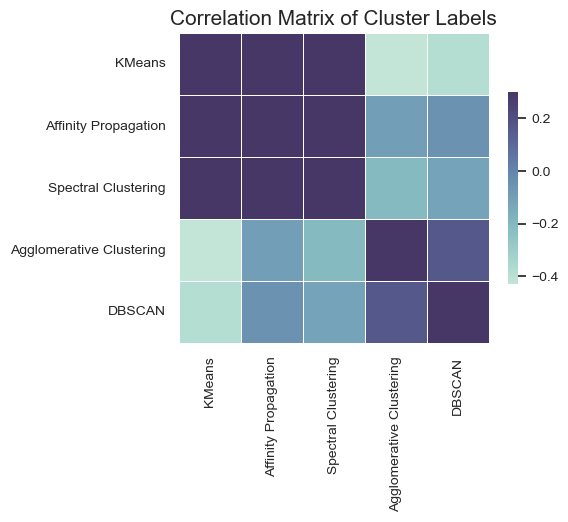

In [26]:
fig, ax = plt.subplots(figsize = (5, 5))
ax.tick_params(labelsize=10)
sns.set(font_scale = 0.5)

plt.title('Correlation Matrix of Cluster Labels', fontsize = 15)

corr = labels_df.corr()
sns.heatmap(corr, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)

#### Answer ####

As shown in the correlation matrix above, certain clustering methods agreed better than others when it came to this dataset. KMeans agreed moderately well with Affinity Propagation and Spectral Clustering but not Agglomerative Clustering or DBSCAN, though those methods agreed somewhat with each other. Without having done much parameter tuning, it is difficult to claim that any of these models performs better than the rest. Spectral Clustering did appear to map well onto KMeans when 4 clusters were specified. I would be eager to examine whether it grouped customers similarly to KMeans according to their buying tendencies.